In [1]:
#pip install pyspark

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing  import LabelEncoder

In [36]:
spark = SparkSession.builder \
    .appName("FinancialFraudDetection") \
    .getOrCreate()

In [5]:
df = spark.read.csv("Synthetic_Financial_datasets_log.csv", header=True, inferSchema=True)

In [6]:
df.head()

Row(step=1, type='PAYMENT', amount=9839.64, nameOrig='C1231006815', oldbalanceOrg=170136.0, newbalanceOrig=160296.36, nameDest='M1979787155', oldbalanceDest=0.0, newbalanceDest=0.0, isFraud=0, isFlaggedFraud=0)

In [7]:
df = df.fillna(0)

# EDA

In [8]:
# Shape of the dataframe
num_rows = df.count()
num_cols = len(df.columns)
print(f"Rows: {num_rows}, Columns: {num_cols}")

Rows: 6362620, Columns: 11


In [9]:
# Data Frame Schema (column names and types)
df.printSchema()

root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = false)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = false)
 |-- newbalanceOrig: double (nullable = false)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = false)
 |-- newbalanceDest: double (nullable = false)
 |-- isFraud: integer (nullable = true)
 |-- isFlaggedFraud: integer (nullable = true)



In [10]:
# Summary statistics for non-numeric columns
df.describe().show()

+-------+------------------+--------+------------------+-----------+------------------+-----------------+-----------+------------------+------------------+--------------------+--------------------+
|summary|              step|    type|            amount|   nameOrig|     oldbalanceOrg|   newbalanceOrig|   nameDest|    oldbalanceDest|    newbalanceDest|             isFraud|      isFlaggedFraud|
+-------+------------------+--------+------------------+-----------+------------------+-----------------+-----------+------------------+------------------+--------------------+--------------------+
|  count|           6362620| 6362620|           6362620|    6362620|           6362620|          6362620|    6362620|           6362620|           6362620|             6362620|             6362620|
|   mean|243.39724563151657|    NULL|179861.90354913156|       NULL| 833883.1040744876|855113.6685785913|       NULL| 1100701.666519651|1224996.3982019257|0.001290820448180152| 2.51468734577894E-6|
| stddev| 

In [11]:
# Count the number of non-null values in each column
for col in df.columns:
    non_null_count = df.filter(df[col].isNotNull()).count()
    print(f"Column '{col}': {non_null_count} non-null values")

Column 'step': 6362620 non-null values
Column 'type': 6362620 non-null values
Column 'amount': 6362620 non-null values
Column 'nameOrig': 6362620 non-null values
Column 'oldbalanceOrg': 6362620 non-null values
Column 'newbalanceOrig': 6362620 non-null values
Column 'nameDest': 6362620 non-null values
Column 'oldbalanceDest': 6362620 non-null values
Column 'newbalanceDest': 6362620 non-null values
Column 'isFraud': 6362620 non-null values
Column 'isFlaggedFraud': 6362620 non-null values


In [12]:
# Generate descriptive statistics for numeric columns
df.describe().show()

+-------+------------------+--------+------------------+-----------+------------------+-----------------+-----------+------------------+------------------+--------------------+--------------------+
|summary|              step|    type|            amount|   nameOrig|     oldbalanceOrg|   newbalanceOrig|   nameDest|    oldbalanceDest|    newbalanceDest|             isFraud|      isFlaggedFraud|
+-------+------------------+--------+------------------+-----------+------------------+-----------------+-----------+------------------+------------------+--------------------+--------------------+
|  count|           6362620| 6362620|           6362620|    6362620|           6362620|          6362620|    6362620|           6362620|           6362620|             6362620|             6362620|
|   mean|243.39724563151657|    NULL|179861.90354913156|       NULL| 833883.1040744876|855113.6685785913|       NULL| 1100701.666519651|1224996.3982019257|0.001290820448180152| 2.51468734577894E-6|
| stddev| 

In [13]:
# Show the count of unique values for each column
from pyspark.sql.functions import countDistinct

for col in df.columns:
    unique_count = df.select(countDistinct(col)).collect()[0][0]
    print(f"Unique values for column {col}: {unique_count}")
    
    # Optional: to display the value counts similar to pandas' value_counts
    df.groupBy(col).count().orderBy('count', ascending=False).show(truncate=False)
    print("======================================================")


Unique values for column step: 743
+----+-----+
|step|count|
+----+-----+
|19  |51352|
|18  |49579|
|187 |49083|
|235 |47491|
|307 |46968|
|163 |46352|
|139 |46054|
|403 |45155|
|43  |45060|
|355 |44787|
|15  |44609|
|186 |43747|
|306 |43615|
|17  |43361|
|259 |43328|
|16  |42471|
|379 |41759|
|14  |41485|
|42  |41304|
|354 |40696|
+----+-----+
only showing top 20 rows

Unique values for column type: 5
+--------+-------+
|type    |count  |
+--------+-------+
|CASH_OUT|2237500|
|PAYMENT |2151495|
|CASH_IN |1399284|
|TRANSFER|532909 |
|DEBIT   |41432  |
+--------+-------+

Unique values for column amount: 5316900
+--------+-----+
|amount  |count|
+--------+-----+
|1.0E7   |3207 |
|10000.0 |88   |
|5000.0  |79   |
|15000.0 |68   |
|500.0   |65   |
|100000.0|42   |
|21500.0 |37   |
|120000.0|29   |
|135000.0|20   |
|0.0     |16   |
|8661.0  |9    |
|2431.38 |9    |
|4648.12 |9    |
|1711.67 |9    |
|5047.67 |9    |
|10180.18|9    |
|3748.95 |9    |
|4546.07 |9    |
|213.86  |9    |
|2152.2

# Data Visualization

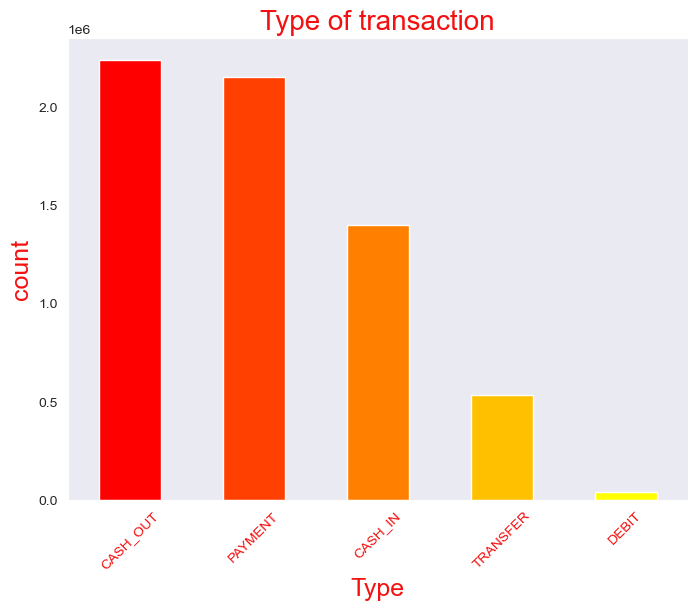

In [14]:
# Convert PySpark DataFrame to Pandas DataFrame for visualization

df_pd = df.select('type').toPandas()


sns.set_style("dark")  
sns.set_palette("pastel")

colors = plt.cm.autumn(np.linspace(0, 1, df_pd['type'].nunique()))

plt.figure(figsize=(8, 6))
df_pd['type'].value_counts().plot(kind='bar', color=colors)
plt.title('Type of transaction', color='#F41010', fontsize=20)
plt.xticks(rotation=45, color='#F41010')
plt.xlabel('Type', fontsize=18, color='#F41010')
plt.ylabel('count', fontsize=18, color='#F41010')
plt.show()

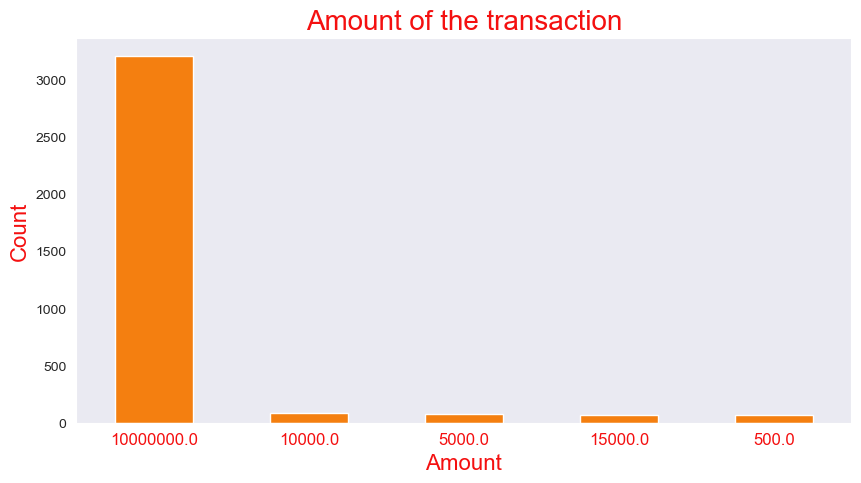

In [15]:
df_pd = df.select('amount').toPandas()

sns.set_style("dark") # set the style of the plot as dark grid
sns.set_palette("pastel")
plt.figure(figsize = (10,5))
df_pd['amount'].value_counts().sort_values(ascending=False).head().plot(kind='bar', color='#F47F10')
plt.title("Amount of the transaction", fontsize=20, color="#F41010")
plt.xticks(rotation=0, fontsize=12, color='#F41010')
plt.xlabel('Amount', fontsize=16, color='#F41010')
plt.ylabel('Count', fontsize=16, color='#F41010')
plt.show()

In [16]:
# Group by 'type' and count 'amount'
type_amount_counts = df.groupBy('type').count().select('type', 'count')
type_amount_counts.show()

+--------+-------+
|    type|  count|
+--------+-------+
|TRANSFER| 532909|
| CASH_IN|1399284|
|CASH_OUT|2237500|
| PAYMENT|2151495|
|   DEBIT|  41432|
+--------+-------+



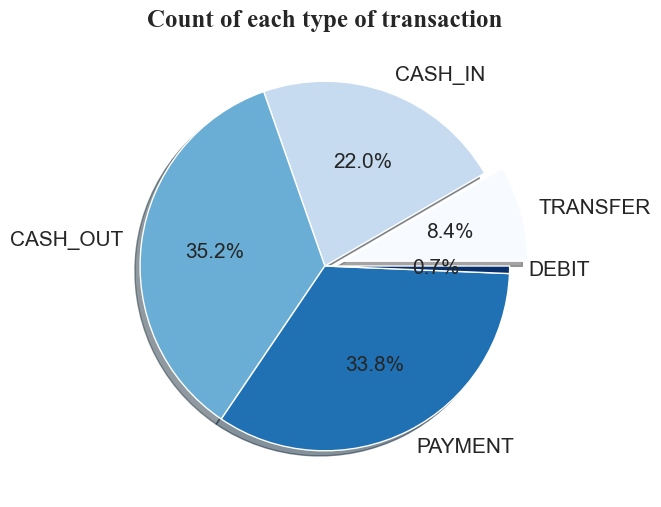

In [17]:
counts_pd = type_amount_counts.toPandas()

colors = plt.cm.Blues(np.linspace(0, 1, counts_pd['count'].nunique()))

plt.figure(figsize=(6, 6))
plt.pie(counts_pd['count'], labels=counts_pd['type'], autopct="%1.1f%%", 
        colors=colors, shadow=True, explode=(0.1, 0, 0, 0, 0),
        textprops={'fontsize': 15})
plt.title('Count of each type of transaction', fontweight='bold', 
          fontsize=18, fontfamily='times new roman')
plt.show()

# Model Training

In [18]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, RFormula
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier,NaiveBayes
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col, when

In [19]:
# Convert categorical columns to numeric using StringIndexer
indexer = StringIndexer(inputCol="type", outputCol="type_indexed")

In [20]:
# Create new features based on balance differences
df = df.withColumn("errorBalanceOrig", col("newbalanceOrig") + col("amount") - col("oldbalanceOrg"))
df = df.withColumn("errorBalanceDest", col("oldbalanceDest") + col("amount") - col("newbalanceDest"))

In [21]:
# Assemble features into a vector
feature_columns = ["type_indexed", "amount", "oldbalanceOrg", "newbalanceOrig",
                   "oldbalanceDest", "newbalanceDest", "errorBalanceOrig", "errorBalanceDest"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

In [22]:
train_data, test_data = df.randomSplit([0.7, 0.3], seed=42)

#### Logistic Regression

In [23]:
# 1. Logistic Regression Model
lr = LogisticRegression(labelCol="isFraud", featuresCol="features")

pipeline_lr =Pipeline(stages=[indexer,assembler,lr])

model_lr =pipeline_lr.fit(train_data)

predictions_lr = model_lr.transform(test_data)

predictions_lr.select("isFraud", "prediction", "probability").show(10, False)

+-------+----------+-------------------------------------------+
|isFraud|prediction|probability                                |
+-------+----------+-------------------------------------------+
|0      |0.0       |[0.9999999999999925,7.549516567451064E-15] |
|0      |0.0       |[1.0,0.0]                                  |
|0      |0.0       |[0.9999999999978386,2.1613821843402548E-12]|
|0      |0.0       |[0.999756127881277,2.4387211872300973E-4]  |
|0      |0.0       |[0.99999999999998,1.9984014443252818E-14]  |
|0      |0.0       |[0.9999999997271769,2.72823097446917E-10]  |
|0      |0.0       |[0.9999940422260808,5.957773919207376E-6]  |
|0      |0.0       |[0.9999999999997891,2.1094237467877974E-13]|
|0      |0.0       |[0.9999536451425386,4.6354857461405885E-5] |
|0      |0.0       |[0.9997827796246149,2.1722037538507433E-4] |
+-------+----------+-------------------------------------------+
only showing top 10 rows



In [24]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator_lr = BinaryClassificationEvaluator(labelCol="isFraud",rawPredictionCol="rawPrediction")
accuracy_lr = evaluator_lr.evaluate(predictions_lr)
print(f"Logistic Regressor Accuracy: {accuracy_lr}")

Logistic Regressor Accuracy: 0.9676456972897505


#### Decision Tree Classifier

In [25]:
# 2. Decision Tree Classifier Model
dt = DecisionTreeClassifier(labelCol="isFraud", featuresCol="features")

# Pipeline: StringIndexer, VectorAssembler, and Decision Tree Classifier
pipeline_dt = Pipeline(stages=[indexer,assembler,dt])

# Fit the model
model_dt = pipeline_dt.fit(train_data)

# Make predictions
predictions_dt = model_dt.transform(test_data)

predictions_dt.select("isFraud", "prediction", "probability").show(10, False)

+-------+----------+-----------+
|isFraud|prediction|probability|
+-------+----------+-----------+
|0      |0.0       |[1.0,0.0]  |
|0      |0.0       |[1.0,0.0]  |
|0      |0.0       |[1.0,0.0]  |
|0      |0.0       |[1.0,0.0]  |
|0      |0.0       |[1.0,0.0]  |
|0      |0.0       |[1.0,0.0]  |
|0      |0.0       |[1.0,0.0]  |
|0      |0.0       |[1.0,0.0]  |
|0      |0.0       |[1.0,0.0]  |
|0      |0.0       |[1.0,0.0]  |
+-------+----------+-----------+
only showing top 10 rows



In [26]:
evaluator_dt = BinaryClassificationEvaluator(labelCol="isFraud",rawPredictionCol="rawPrediction")
accuracy_dt = evaluator_dt.evaluate(predictions_dt)
print(f"Decision Tree Classifier Accuracy: {accuracy_dt}")

Decision Tree Classifier Accuracy: 0.9986587346858958


#### Random Forest Classifier

In [28]:
# 4. Random Forest Classifier
rf = RandomForestClassifier(labelCol="isFraud", featuresCol="features", numTrees=100)

pipeline_rf = Pipeline(stages=[indexer, assembler, rf])

model_rf = pipeline_rf.fit(train_data)

predictions_rf = model_rf.transform(test_data)
predictions_rf.select("isFraud", "prediction", "probability").show(10, False)

+-------+----------+------------------------------------------+
|isFraud|prediction|probability                               |
+-------+----------+------------------------------------------+
|0      |0.0       |[0.9998195838634517,1.8041613654836612E-4]|
|0      |0.0       |[0.99983878566975,1.6121433024988334E-4]  |
|0      |0.0       |[0.9998523527030718,1.4764729692819657E-4]|
|0      |0.0       |[0.9998523240224126,1.4767597758728082E-4]|
|0      |0.0       |[0.9998524630211061,1.4753697889392748E-4]|
|0      |0.0       |[0.9998195838634517,1.8041613654836612E-4]|
|0      |0.0       |[0.9998522137043784,1.477862956215499E-4] |
|0      |0.0       |[0.9998524630211061,1.4753697889392748E-4]|
|0      |0.0       |[0.9998523240224126,1.4767597758728082E-4]|
|0      |0.0       |[0.9998194448647583,1.8055513524171943E-4]|
+-------+----------+------------------------------------------+
only showing top 10 rows



In [29]:
evaluator_rf = BinaryClassificationEvaluator(labelCol="isFraud",rawPredictionCol="rawPrediction")
accuracy = evaluator_rf.evaluate(predictions_rf)
print(f"Random Forest Classifier Accuracy: {accuracy}")

Random Forest Classifier Accuracy: 0.9988321627452084


### Random Forest Classifier has the highest accuracy

In [39]:
spark.stop()